Exercise-based on a dataset published on Kaggle: https://www.kaggle.com/sakshigoyal7/credit-card-customers

**Goal:** Finding a model which can predict which credit card clients are gonna get churned.

**Propouse:**
- Accomplishing an exploratory data analysis on the dataset.
- Identifying and dealing with possible skewed data, where applicable.
- Accomplishing hypothesis tests by analyzing data variation, where applicable.
- Accomplishing normality tests.
- Identifying possible correlations.
- Accomplishing oversampling or undersampling techniques to solve possible imbalance problem, if necessary.
- Solving possible overfitting and underfitting problems, if necessary.
- Accomplishing data normalization and coeficient regularization techniques, if necessary.
- Finding which algorithm have the best performance: Naïve Bayes, Logistic Regression, Tree Decision, Random Forest, and SVC
- Applying K-Fold cross-validation.
- Validating results with confusion matrix
- Checking algorithms' results variability.

**Solution author's Linkedin profile:** https://bit.ly/3tsOnU3

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import os
import math
import statsmodels.api as sm
import scipy.stats as stats
from imblearn.under_sampling import AllKNN, TomekLinks, EditedNearestNeighbours, CondensedNearestNeighbour
from imblearn.under_sampling import InstanceHardnessThreshold, RepeatedEditedNearestNeighbours, OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler, BorderlineSMOTE, SMOTENC, SMOTEN
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from scipy.stats import norm, shapiro
import warnings

warnings.filterwarnings("ignore")
abs_path = os.getcwd()

# 1. Get dataset by Kaggle API

In [2]:
parquet_file = "bancChurners.parquet"
csv_file = "BankChurners.csv"
zip_file = "credit-card-customers.zip"

if os.path.isfile(parquet_file):
    print ("There is a parquet file!!!")
    dataset = pd.read_parquet(parquet_file)
else:
    """
    Get the compressed dataset (.zip file), 
    Extract .csv file,
    Deletr .zip file,
    Load .csv jupyter to jupyter notebook,
    Delete .csv file,
    Generate .parquet file
    """
    print ("There is no file")
    !kaggle datasets download -d sakshigoyal7/credit-card-customers
    with zipfile.ZipFile(zip_file,"r") as zip_ref:
        zip_ref.extractall(abs_path)
    os.remove(zip_file)
    dataset = pd.read_csv(csv_file)
    dataset.to_parquet(parquet_file, engine='pyarrow')
    os.remove(csv_file)
    
dataset.head()

There is a parquet file!!!


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


# 2. Exploratory Data Analysis

In [3]:
dataset.shape

(10127, 23)

**Note:** according to this dataset author on Kaggle, two last columns must be deleted.

In [4]:
dataset.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', axis=1, inplace=True)
dataset.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', axis=1, inplace=True)
dataset.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


**Analysis:** By getting "non-null" results below, it proves:
- There is no null data, so there is no need to delete elements/columns or to add data by interpolation.

**Analysis:** Between explicative variables, there are some qualitative variables ("object" type), quantiative ones - discrete (most of them of "int64" type) and continuous (most of them of "float64"). 
After a deep analysis, it was noted that some variables could have their type converted from "int64" to "float64", for this context - "Total_Trans_Amt" (Total Transaction Amount) and "Total_Revolving_Bal" (Total Revolving Balance on the Credit Card). Because they represent the sum of continuous values.

**Analysis:** Afterwards, it was noticed it is necessary to apply data normalization technique to some columns.

In [5]:
dataset['Total_Trans_Amt'] = dataset['Total_Trans_Amt'].astype(np.float64)
dataset['Total_Revolving_Bal'] = dataset['Total_Revolving_Bal'].astype(np.float64)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [6]:
dataset.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


**Analysis:** The response variable, 'Attrition_Flag', is unbalanced between its classes - 'Attrited Customer' and 'Existing Customer'. Then, some undersampling or oversampling technique must be applied on dataset in order to remove elements or add some synthetic elements.

**Analysis:** There are skewed data in some columns and it can be seen on quantitative explicative variables' histograms and on their boxplots.

In [7]:
np.unique(dataset['Attrition_Flag'], return_counts=True)

(array(['Attrited Customer', 'Existing Customer'], dtype=object),
 array([1627, 8500], dtype=int64))

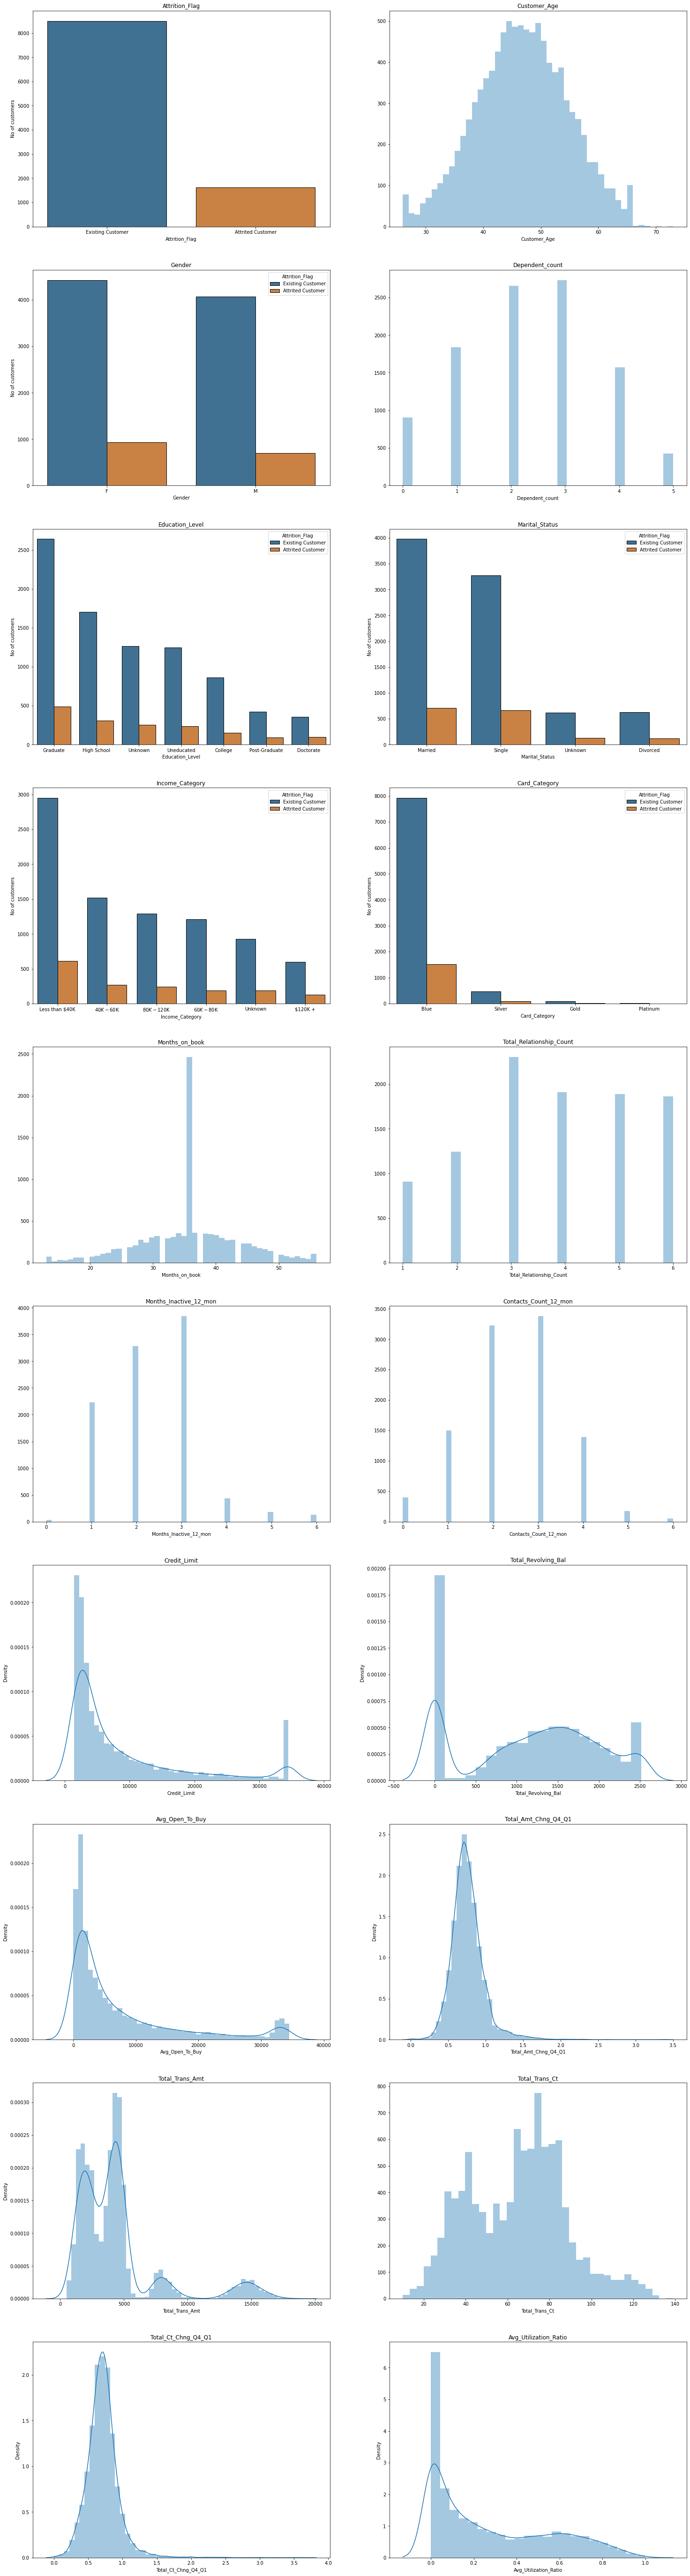

In [8]:
subplot_columns_amount = 2
first_index = 1
subplot_rows_amount = math.ceil(len(dataset.iloc[:,first_index:].columns)/subplot_columns_amount)

_, ax = plt.subplots(subplot_rows_amount, subplot_columns_amount, figsize=(25,100))

for count, column in enumerate(dataset.iloc[:,first_index:].columns):
    current_ax = ax[count//subplot_columns_amount][count%subplot_columns_amount]
    current_ax.set_title(column)
    if dataset[column].dtype in ["int64", "float64"]:
        kde = True if dataset[column].dtype == "float64" else False
        sns.distplot(dataset[column], kde=kde, ax=current_ax)
    else:
        data = pd.DataFrame(dataset[column].groupby(dataset[column]).size().reset_index(name='Amount'))
        current_ax.set_ylabel("No of customers")
        # Descending ordering based on element amount for each class of each column
        # Afterwards, reshaping operation is needed after .value, because it returns a matrix
        order = dataset[column].groupby(dataset[column]).size().reset_index(name='cost_amnt').sort_values(by=['cost_amnt'], ascending=False).iloc[:,:1].values
        hue=dataset['Attrition_Flag'] if column != "Attrition_Flag" else None
        sns.countplot(x = dataset[column], edgecolor = 'black', saturation = 0.55, 
                          ax=current_ax, hue=hue, order=order.reshape((order.shape[0])))
        current_ax.set_ylabel('No of customers')
        
# Delete empty frames
qtd_frames_vazios = subplot_columns_amount*subplot_rows_amount - len(dataset.iloc[:,first_index:].columns)
[ax.flat[-i].set_visible(False) for i in range(1, qtd_frames_vazios+1)]
plt.show()
plt.close()

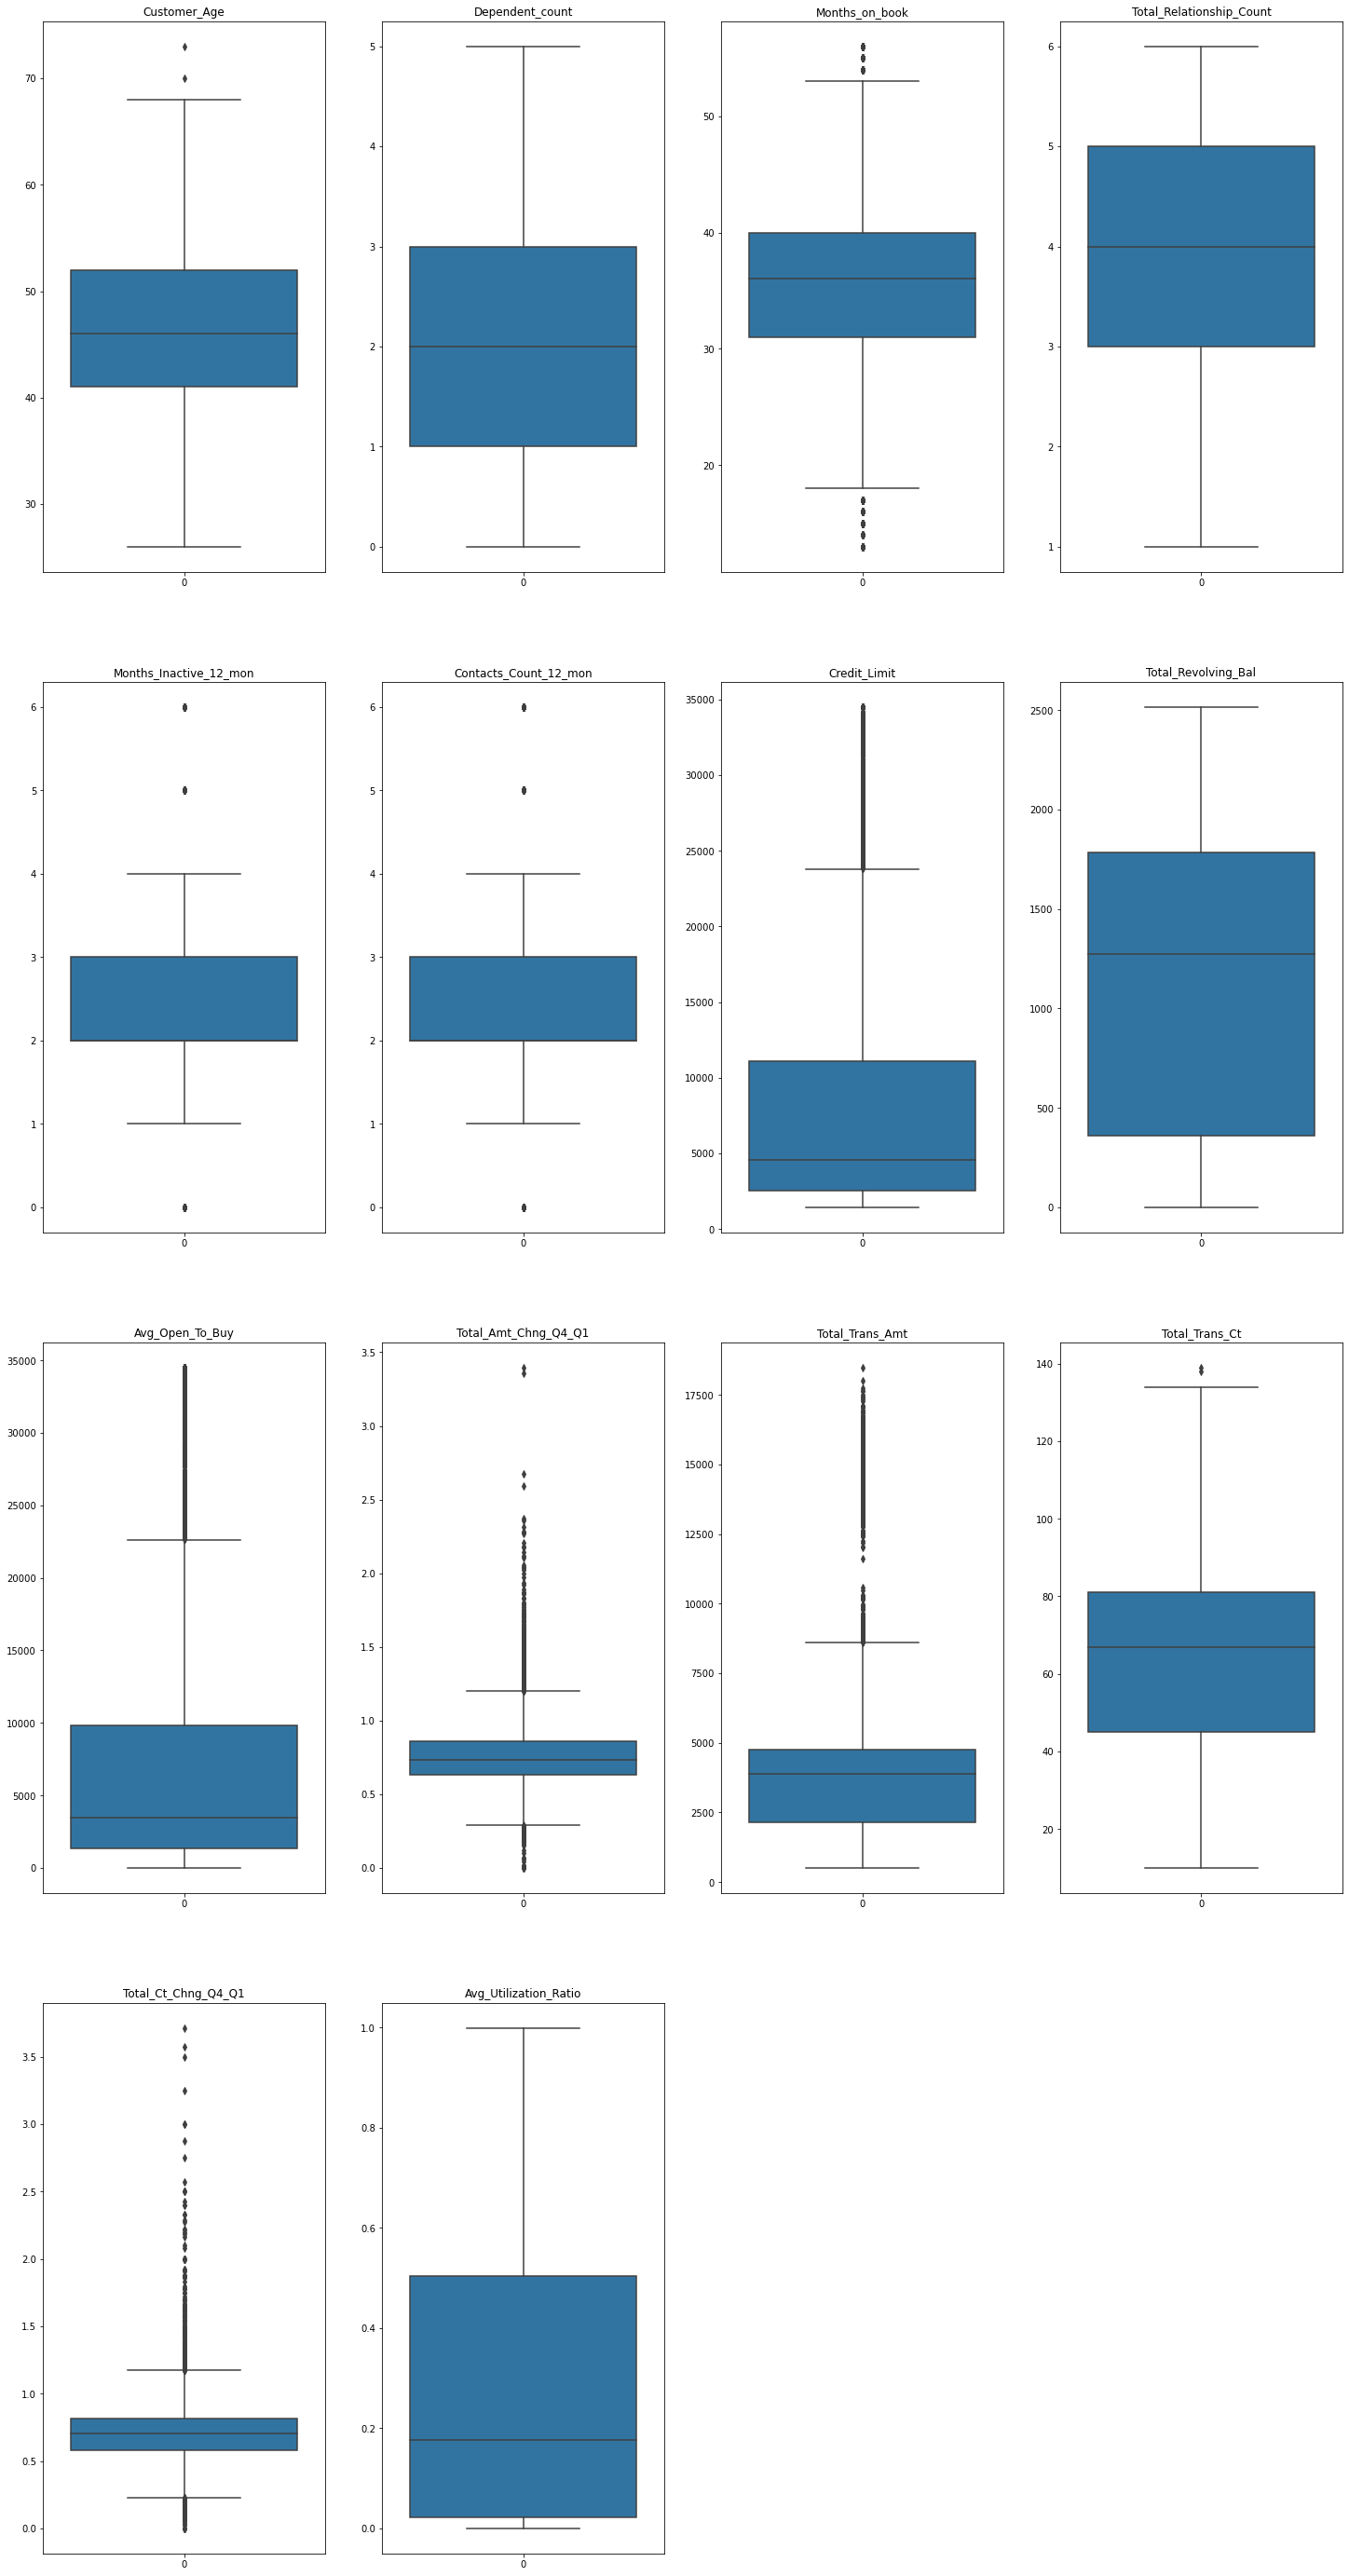

In [9]:
numeric_columns = (dataset.iloc[:,1:].dtypes != "object").reset_index(name='Amount').query('Amount == True')['index'].values

subplot_columns_amount = 4
subplot_rows_amount = math.ceil(len(numeric_columns)/subplot_columns_amount)
_, ax = plt.subplots(subplot_rows_amount, subplot_columns_amount, figsize=(25,50))

for count, column in enumerate(numeric_columns):
    current_ax = ax[count//subplot_columns_amount][count%subplot_columns_amount]
    current_ax.set_title(column)
    plt.subplot(sns.boxplot(data=dataset[column], ax=current_ax))

# Delete empty frames
amount_empty_frames = subplot_columns_amount*subplot_rows_amount - len(numeric_columns)
[ax.flat[-i].set_visible(False) for i in range(1, amount_empty_frames+1)]
plt.show()
plt.close()

In [10]:
# Encode data

dataset_encoded = dataset.iloc[:,1:].copy()

for column in dataset_encoded.columns:
    if dataset_encoded[column].dtype == "object":
        label_encoder = LabelEncoder()
        dataset_encoded[column] = label_encoder.fit_transform(dataset_encoded[column])

**Analysis:** The heatmap for Pearson correlation table below proves no explicative variable is, at least, on moderate level, according to Evans classification, Evans (1996, also http://leg.ufpr.br/~silvia/CE003/node74.html, on Brazilian portuguese)

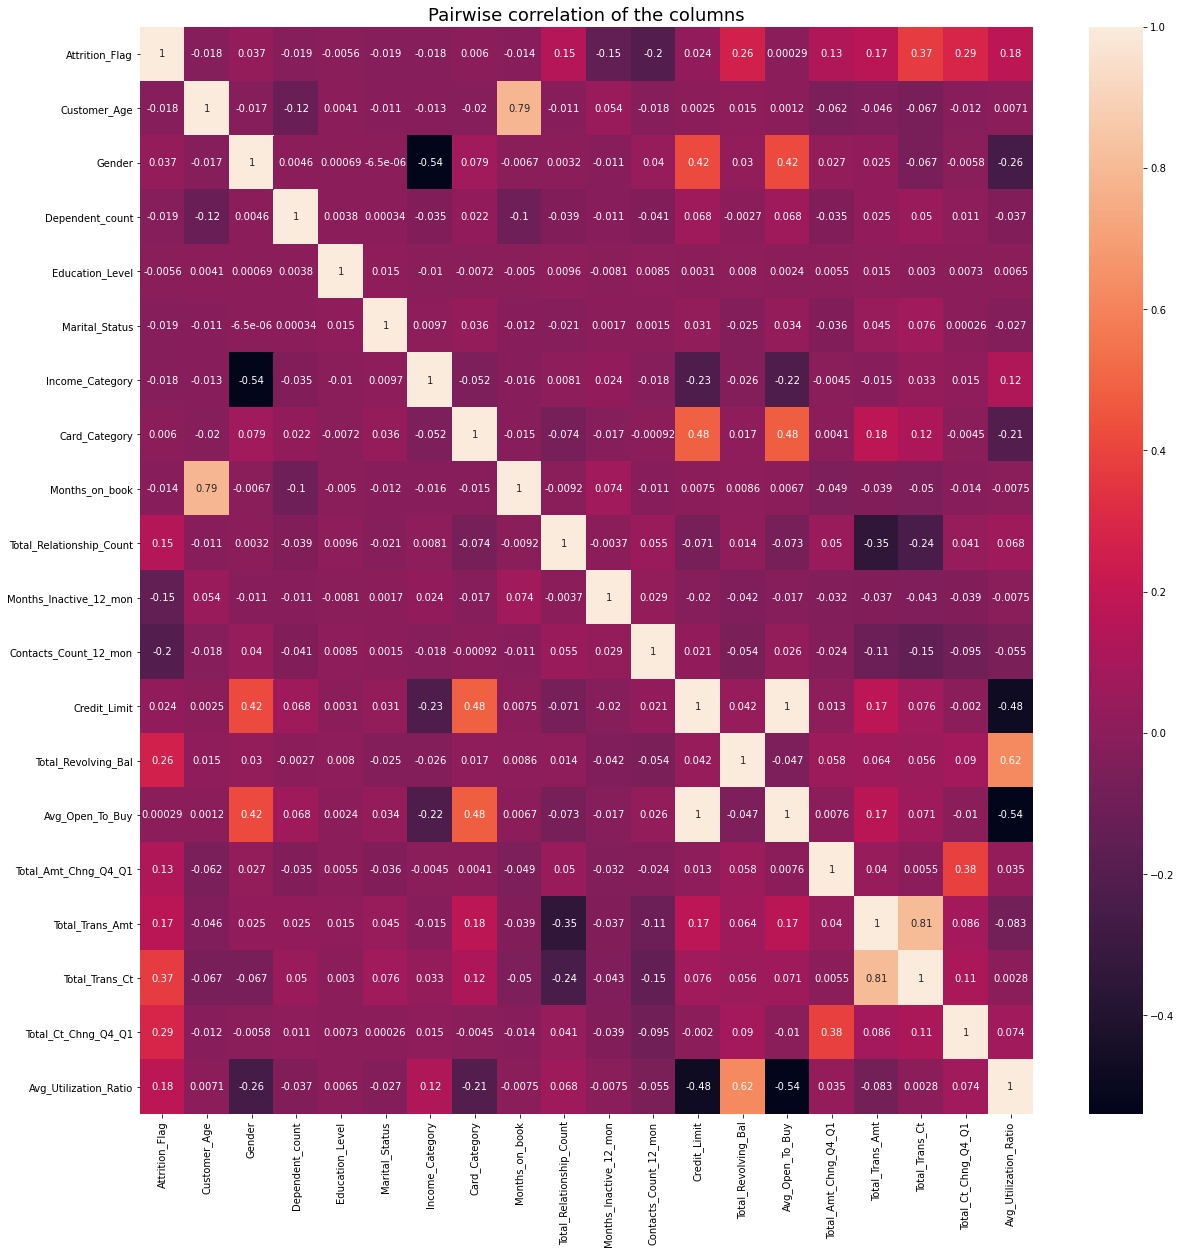

In [11]:
fig, ax = plt.subplots(figsize = (20, 20))
plt.title("Pairwise correlation of the columns", fontsize = 18)
ax = sns.heatmap(dataset_encoded.iloc[:,:].corr(), annot = True)

**Analysis:** Pairwise relationships graphics below proves it's going to be hard to the algorithms learning how to distinguish elements from both classes. Probably, undersampling techniques can solve this problem. Also, oversampling can solve the unbalanced data problem.

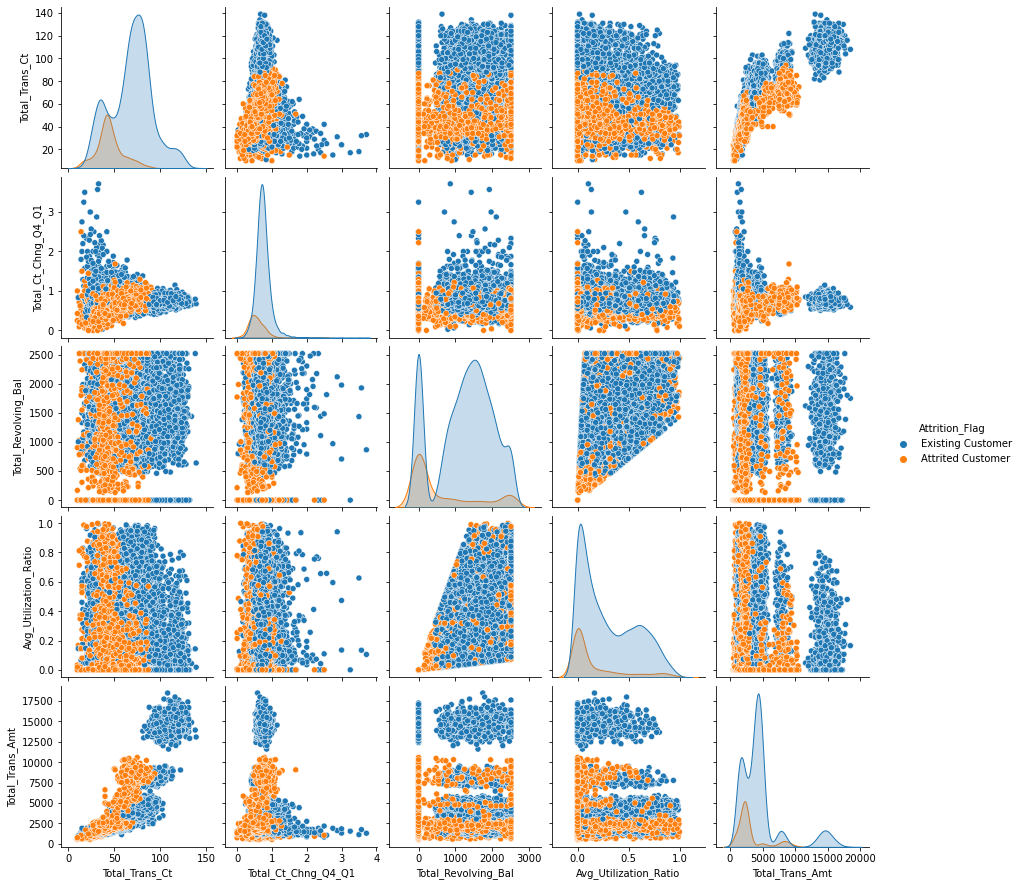

In [12]:
vars = ['Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal', 'Avg_Utilization_Ratio', 
        'Total_Trans_Amt']
sns.pairplot(dataset, vars=vars, hue = "Attrition_Flag")
plt.show()

# 3. Data Prep

**Analisys:** No transformation was applied to skewed variables, because none of them (Log and Square trasnformation) resulted in a good distribution. Analyzed columns: 'Credit_Limit', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Total_Trans_Amt', 'Total_Revolving_Bal'.
So, RobustScaler is recommended to use in this columns during model training (see https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02).

In [13]:
dataset_encoded_transformed = dataset_encoded.copy()

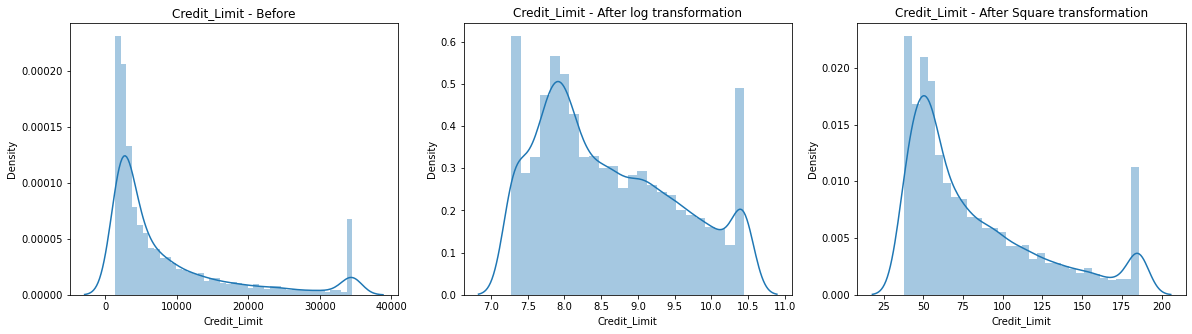

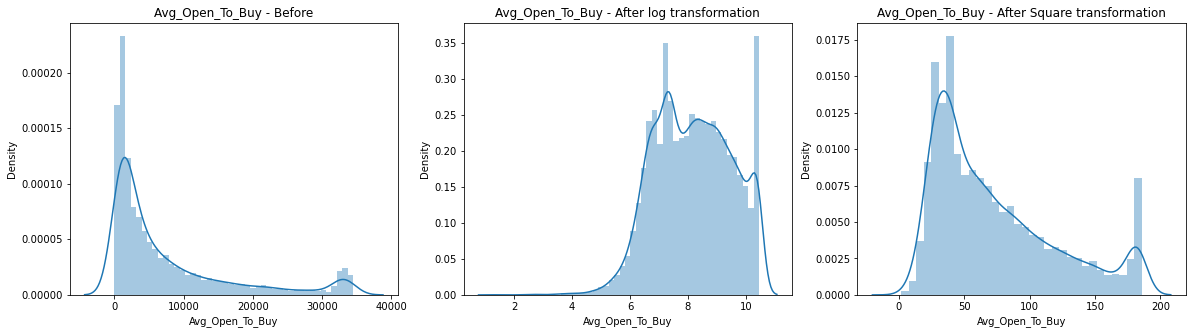

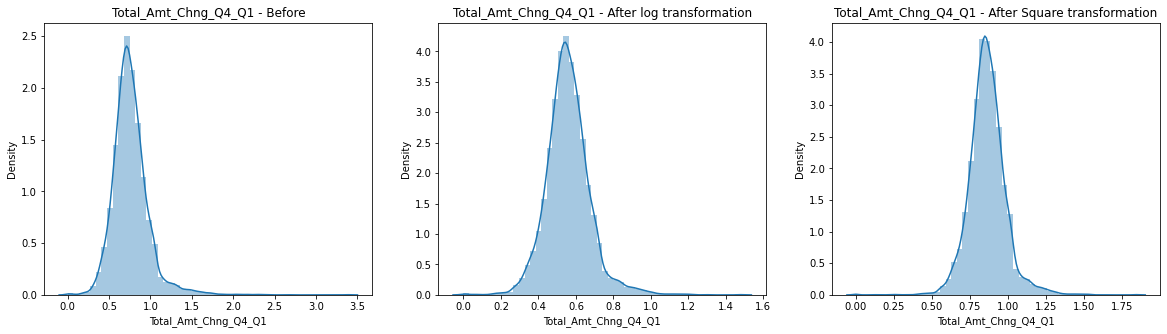

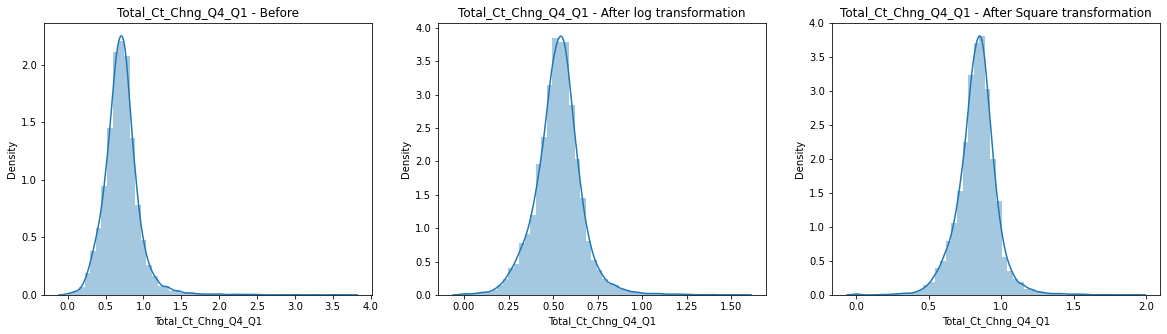

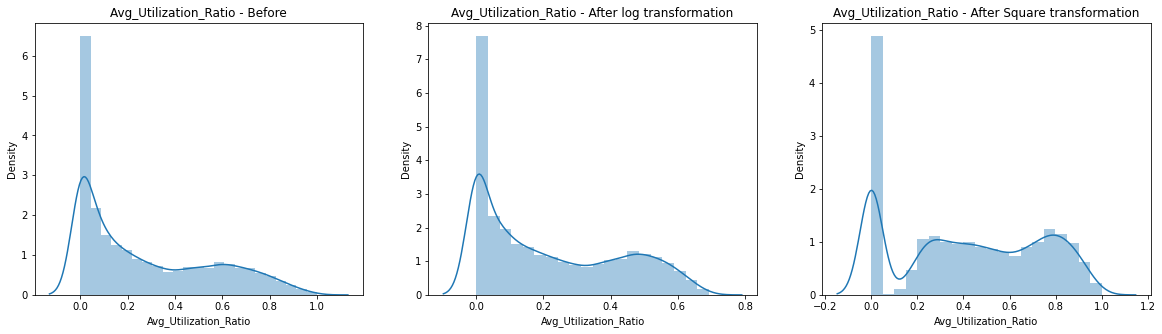

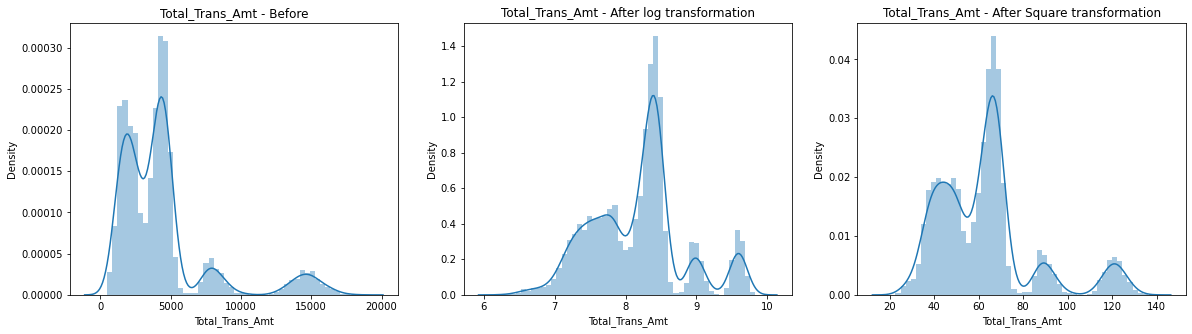

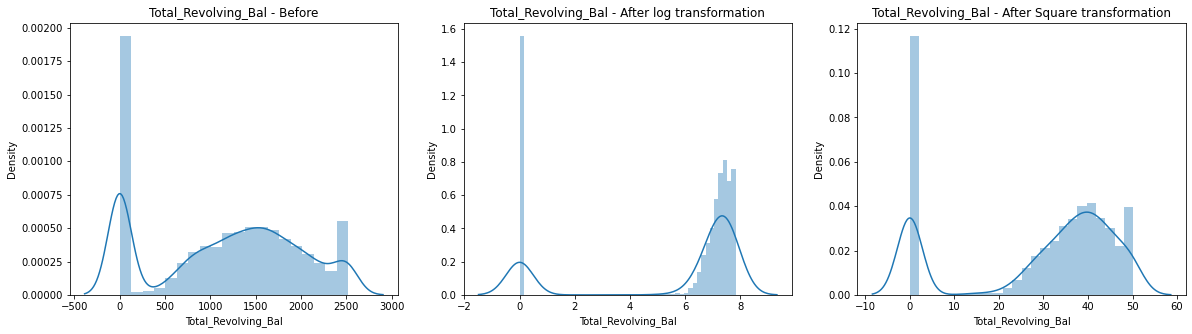

In [14]:
tranform_col_list = ['Credit_Limit','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1',
                     'Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio','Total_Trans_Amt', 'Total_Revolving_Bal']
for column in tranform_col_list:
    _, ax = plt.subplots(1, 3, figsize=(20,5))
    ax[0].set_title(column + " - Before")
    sns.distplot(dataset_encoded_transformed[column], kde=True, ax=ax[0])
    ax[1].set_title(column + " - After log transformation")
    sns.distplot(np.log1p(dataset_encoded_transformed[column]), kde=True, ax=ax[1])
    ax[2].set_title(column + " - After Square transformation")
    sns.distplot(np.sqrt(dataset_encoded_transformed[column]), kde=True, ax=ax[2])

# 4. Model training 

## 4.1. No treatment applied on models - With skewed data, no attribute selection, normalized data with Standard Scaler, dataset size for test 30%

In [15]:
x, y = dataset_encoded.iloc[:,1:], dataset_encoded.iloc[:,:1]

In [16]:
def plot_algorithms_scores_comparison(results_dict):
    plt.figure(figsize = (12,6)) 
    mean_score_list = []
    [mean_score_list.append(results_dict[key]["results"].mean()) for key in results_dict]
    ax = sns.barplot(list(results_dict.keys()), mean_score_list)
    ax.set_xticklabels(list(results_dict.keys()), fontsize = 18, rotation = 90)
    plt.title("Comparison of the models", fontsize = 18)
    plt.ylabel("Forecast accuracy")
    plt.show()
    plt.close()
        
def calculate_plot_confusion_matrix(results):
    subplot_columns_amount = 3
    subplot_rows_amount = int(math.ceil(len(list(results[0].keys()))/subplot_columns_amount))
    _, ax = plt.subplots(subplot_rows_amount, subplot_columns_amount, figsize=(20,12))
    
    for index, key in enumerate(results[0]):
        current_ax = ax[index//subplot_columns_amount][index%subplot_columns_amount]
        confusion_matrix_response = confusion_matrix(results[0][key]["prediction"], results[1])
        tn, fp, fn, tp = confusion_matrix_response.ravel()
        confusion_matrix_values = "TN: {} - FP: {} - FN: {} - TP: {}".format(tn,fp,fn,tp)
        current_ax.set_title("{}\n{}\n".format(key, confusion_matrix_values))
        sns.heatmap(confusion_matrix_response, annot=True, ax=current_ax)
        
def plot_confusion_matrix(matrix, algoritmos):
    subplot_columns_amount = 3
    subplot_rows_amount = int(math.ceil(len(matrix)/subplot_columns_amount))
    _, ax = plt.subplots(subplot_rows_amount, subplot_columns_amount, figsize=(20,12))
    
    for index, (score,algoritmo) in enumerate(zip(list(matrix),algoritmos)):
        current_ax = ax[index//subplot_columns_amount][index%subplot_columns_amount]
        tn, fp, fn, tp = matrix[index].ravel()
        confusion_matrix_values = "TN: {} - FP: {} - FN: {} - TP: {}".format(tn,fp,fn,tp)
        current_ax.set_title("{}\n{}\n".format(algoritmo, confusion_matrix_values))
        sns.heatmap(matrix[index], annot=True, ax=current_ax)
    
def plot_scores_distplot(results_dict):
    plt.figure(figsize=(20,10))
    colors = ["red", "blue", "green", "orange", "brown", "gray"]

    for index,key in enumerate(results_dict):
        plt.subplot(2, len(list(results_dict.keys()))/2, index+1)
        plt.title(key)
        plt.subplot(sns.distplot(results_dict[key]["results"], 
                                 color=colors[index], label=key, hist=True, kde=False, axlabel="Accuracy"))
        plt.legend();
    
def plot_confidence_interval(results_dict):
    for key in results_dict:
        print("Confidence interval - {:<20}: {}".format(key, 
                                                        norm.interval(0.95, 
                                                                      results_dict[key]["results"].mean(),
                                                                      stats.sem(results_dict[key]["results"]))))

def plot_roc_curve(results_dict):
    plt.figure(figsize=(20,10))
    lw = 2
    colors = ["red", "blue", "green", "orange", "brown", "gray"]
    for index, key in enumerate(results_dict):
        plt.plot(results_dict[key]["fpr"], results_dict[key]["tpr"], color=colors[index], lw=lw,
             label='ROC curve of class {0} (avg. area = {1:0.4f})'
             ''.format(key, np.mean(results_dict[key]["auc"])))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve table')
    plt.legend(loc="lower right")
        
def plot_statistics(results_dict):
    print("Accuracy Mean:")
    for key in results_dict:
        print("\t{:<25}: {:.5} %".format(key, results_dict[key]["results"].mean()))
    print("Standard deviation:")
    for key in results_dict:
        print("\t{:<25}: {:.5}".format(key, np.std(results_dict[key]["results"])))
    print("Coefficient of variation:")
    for key in results_dict:
        print("\t{:<25}: {:.5}".format(key, stats.variation(results_dict[key]["results"])))
        
def get_model(model_name, variables_dict, random_state):
    if model_name == "Naive":
        variables_dict[model_name]["model"] = GaussianNB()
    elif model_name == "Logistic":
        variables_dict[model_name]["model"] = LogisticRegression(random_state = random_state)
    elif model_name == "Forest":
        variables_dict[model_name]["model"] = RandomForestClassifier(random_state = random_state)
    elif model_name == "Tree":
        variables_dict[model_name]["model"] = DecisionTreeClassifier(random_state = random_state)
    elif model_name == "SVC":
        variables_dict[model_name]["model"] = SVC(random_state = random_state)
    elif model_name == "kNN":
        variables_dict[model_name]["model"] = KNeighborsClassifier()
        
def train(x, y, train_loop, norm=0):
    variables = {
        "Naive":      { "results": [], "prediction": 0, "model": None, "fpr": [], "tpr": [], "auc": [] },
        "Logistic":   { "results": [], "prediction": 0, "model": None, "fpr": [], "tpr": [], "auc": [] },
        "Forest":     { "results": [], "prediction": 0, "model": None, "fpr": [], "tpr": [], "auc": [] },
        "Tree":       { "results": [], "prediction": 0, "model": None, "fpr": [], "tpr": [], "auc": [] },
        "SVC":        { "results": [], "prediction": 0, "model": None, "fpr": [], "tpr": [], "auc": [] },
        "kNN":        { "results": [], "prediction": 0, "model": None, "fpr": [], "tpr": [], "auc": [] },
    }
    
    for i in range(train_loop):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify = y, random_state = i)
        # data normalization during training
        if norm == 1:
            st = StandardScaler()
            x_train = st.fit_transform(x_train)
            x_test = st.transform(x_test)
        elif norm == 2:
            rs = RobustScaler()
            x_train = rs.fit_transform(x_train)
            x_test = rs.transform(x_test)
            
        for key in variables:        
            get_model(key, variables, random_state = i)
            variables[key]["model"].fit(x_train, y_train)
            variables[key]["prediction"] = variables[key]["model"].predict(x_test)
            variables[key]["results"].append(accuracy_score(y_test, variables[key]["prediction"]))
            
            fpr, tpr, tr = roc_curve(np.reshape(y_test,y_test.shape[0]), variables[key]["prediction"])
            variables[key]["fpr"].append(fpr)
            variables[key]["tpr"].append(tpr)
    
    for key in variables:
        variables[key]["results"] = np.array(variables[key]["results"])
        variables[key]["fpr"] = np.mean(variables[key]["fpr"], axis=0)
        variables[key]["tpr"] = np.mean(variables[key]["tpr"], axis=0)
        variables[key]["auc"].append(auc(variables[key]["fpr"], variables[key]["tpr"]))
    return [variables, y_test]

def train_kfold(x, y, train_loop):
    variables = {
        "Naive":      { "results": [] },
        "Logistic":   { "results": [] },
        "Forest":     { "results": [] },
        "Tree":       { "results": [] },
        "SVC":        { "results": [] },
        "kNN":        { "results": [] },
    }
    resultados_naive_bayes = []
    resultados_logistic = []
    resultados_forest = []
    resultados_decision_tree = []
    resultados_svc = []
    resultados_knn = []
    confusion_kfold = []

    for i in range(train_loop):
        kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
        
        modelos = [GaussianNB(), 
                   LogisticRegression(), 
                   RandomForestClassifier(), 
                   DecisionTreeClassifier(), 
                   SVC(),
                   KNeighborsClassifier()]
        
        for index, key in enumerate(list(variables.keys())):
            scores = cross_val_score(modelos[index], x, y, cv = kfold)
            variables[key]["results"].append(scores.mean())
        
        if i == 0:
            [confusion_kfold.append(confusion_matrix(cross_val_predict(modelo, x, y, cv=10), y)) for modelo in modelos]
        else:
            for index, modelo in enumerate(modelos):
                confusion_kfold[index] = confusion_kfold[index] + confusion_matrix(cross_val_predict(modelo, x, y, cv=10), y)
    
    for key in variables:
        variables[key]["results"] = np.array(variables[key]["results"])
    return [variables, confusion_kfold]

def plot_models_analysis(results):    
    # Mean, Standard Deviation, and Coefficient of variation
    plot_statistics(results[0])
    
    # Models results' comparison
    plot_algorithms_scores_comparison(results[0])
    
    # Confidence interval
    plot_confidence_interval(results[0])
    
    # ROC Curve
    plot_roc_curve(results[0])
    
    # Confusion Matrix
    calculate_plot_confusion_matrix(results)
        
    # Results Variation
    plot_scores_distplot(results[0])
    
def plot_kfold_analysis(results_kfold):
    # Mean, Standard Deviation, and Coefficient of variation
    plot_statistics(results_kfold[0])
    
    # Models results' comparison
    plot_algorithms_scores_comparison(results_kfold[0])

    # Confidence interval
    plot_confidence_interval(results_kfold[0])
    
    # Confusion Matrix
    plot_confusion_matrix(results_kfold[1], list(results_kfold[0].keys()))

    # Results Variation
    plot_scores_distplot(results_kfold[0])

Accuracy Mean:
	Naive                    : 0.88723 %
	Logistic                 : 0.90358 %
	Forest                   : 0.96209 %
	Tree                     : 0.93634 %
	SVC                      : 0.93017 %
	kNN                      : 0.90611 %
Standard deviation:
	Naive                    : 0.0055036
	Logistic                 : 0.0029204
	Forest                   : 0.0027654
	Tree                     : 0.0041966
	SVC                      : 0.0029656
	kNN                      : 0.0046917
Coefficient of variation:
	Naive                    : 0.0062031
	Logistic                 : 0.003232
	Forest                   : 0.0028743
	Tree                     : 0.0044819
	SVC                      : 0.0031883
	kNN                      : 0.0051778


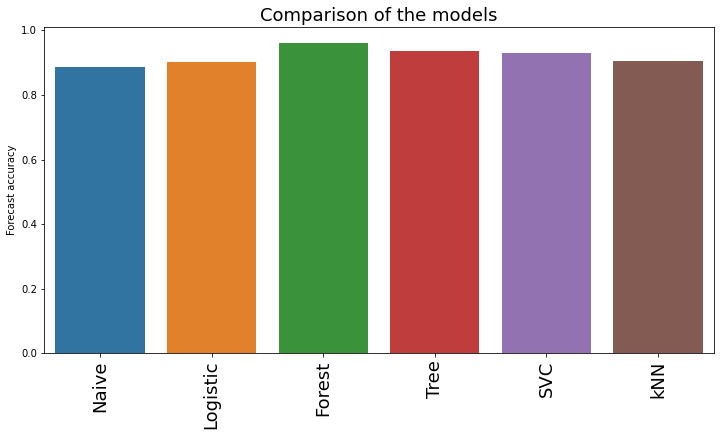

Confidence interval - Naive               : (0.885229562454787, 0.8892357221783158)
Confidence interval - Logistic            : (0.9025128519375273, 0.9046386233284595)
Confidence interval - Forest              : (0.9610863192501107, 0.9630992681141537)
Confidence interval - Tree                : (0.9348113390115991, 0.9378660768050073)
Confidence interval - SVC                 : (0.9290950360235912, 0.931253762923431)
Confidence interval - kNN                 : (0.9044019088201604, 0.907817022845958)


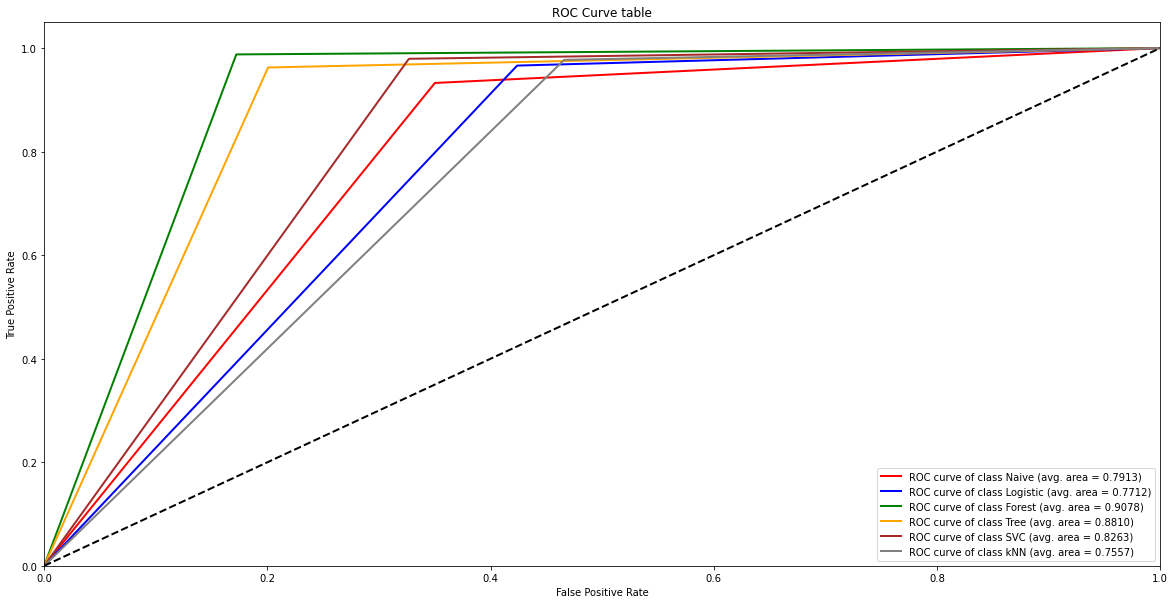

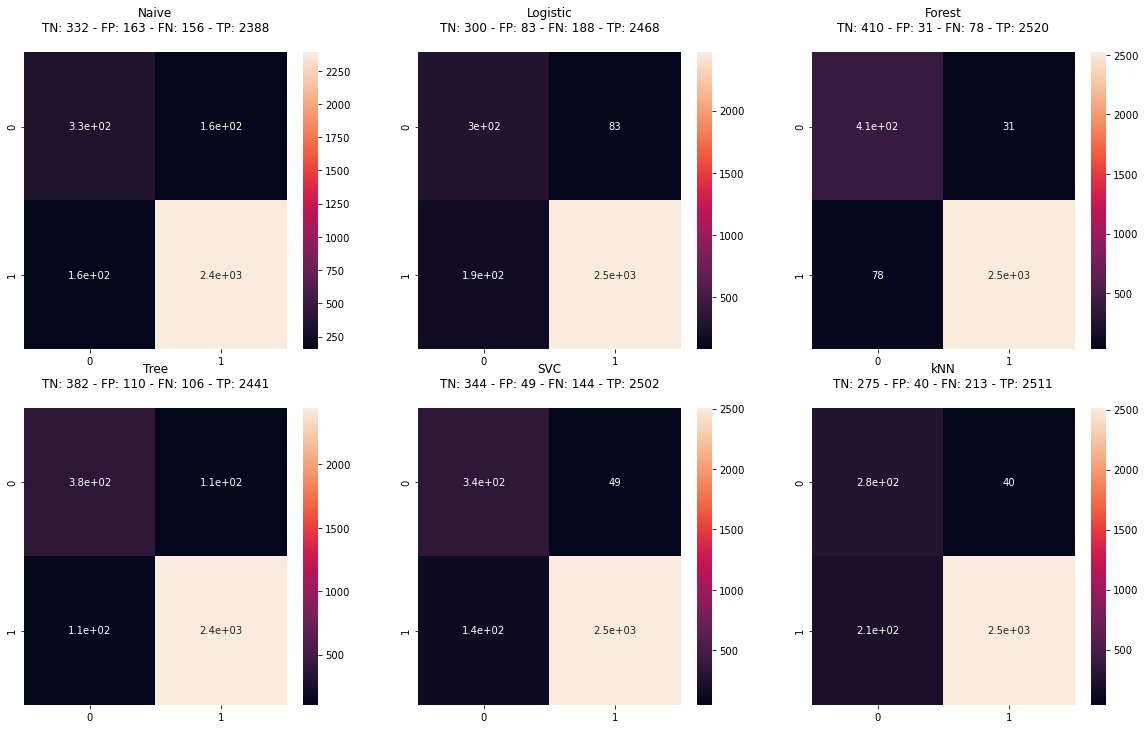

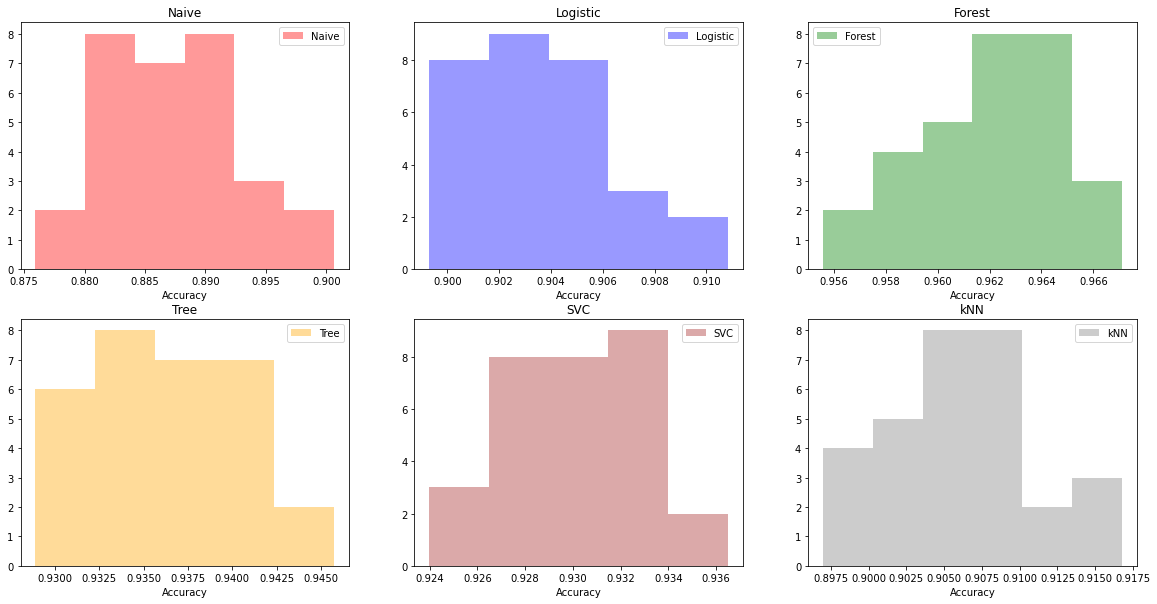

In [17]:
def train_models(x, y):
    train_loop = 30
    return train(x, y, train_loop, 1)
    
results = train_models(x, y)
plot_models_analysis(results)

## 4.2. Oversampling and Undersampling Technique - With skewed data, no attribute selection, normalized data with Standard Scaler, dataset size for test 30%

**Analysis:** Some undersamping techniques were tested and the best one was the "Repeated Edited Nearest Neighbours".
Undersampling techniques that were tested:
- Tomek Links
- Nearest Neighbours Technique
- AllKNN
- Condensed Nearest Neighbors
- Repeated Edited Nearest Neighbours
- One Sided Selection
- Neighbourhood Cleaning Rule

**Analysis:** Some oversamping techniques were tested and the best one was the "Random Over Sampler".
Undersampling techniques that were tested:
- Random Over Sampler
- SMOTE
- ADASYN
- Borderline SMOTE
- SMOTEN

In [18]:
'''
    # UnderSampling models
    # Tomek Links Technique

    def train_models(x, y):
        train_loop = 30

        tl = TomekLinks(sampling_strategy='majority')
        x_under, y_under = tl.fit_resample(x, y)

        return train(x_under, y_under, train_loop, 1)

    results = train_models(x, y)
    plot_models_analysis(results)

    # Nearest Neighbours Technique 

    def train_models(x, y):
        train_loop = 30

        enn = EditedNearestNeighbours(sampling_strategy='majority')
        x_under, y_under = enn.fit_resample(x, y)

        return train(x_under, y_under, train_loop, 1)

    results = train_models(x, y)
    plot_models_analysis(results)

    # AllKNN

    def train_models(x, y):
        train_loop = 30

        allknn = AllKNN(sampling_strategy='majority')
        x_under, y_under = allknn.fit_resample(x, y)

        return train(x_under, y_under, train_loop, 1)

    results = train_models(x, y)
    plot_models_analysis(results)

    # Condensed Nearest Neighbors

    def train_models(x, y):
        train_loop = 30

        cnn = CondensedNearestNeighbour(sampling_strategy='majority')
        x_under, y_under = cnn.fit_resample(x, y)

        return train(x_under, y_under, train_loop, 1)

    results = train_models(x, y)
    plot_models_analysis(results)

    # One Sided Selection

    def train_models(x, y):
        train_loop = 30

        oss = OneSidedSelection(sampling_strategy='majority')
        x_under, y_under = oss.fit_resample(x, y)

        return train(x_under, y_under, train_loop, 1)

    results = train_models(x, y)
    plot_models_analysis(results)

    # Neighbourhood Cleaning Rule

    def train_models(x, y):
        train_loop = 30

        cr = NeighbourhoodCleaningRule(sampling_strategy='majority')
        x_under, y_under = cr.fit_resample(x, y)

        return train(x_under, y_under, train_loop, 1)

    results = train_models(x, y)
    plot_models_analysis(results)

    # Repeated Edited Nearest Neighbours
    def train_models(x, y):
        train_loop = 30

        rnn = RepeatedEditedNearestNeighbours(sampling_strategy='majority')
        x_under, y_under = rnn.fit_resample(x, y)

        return train(x_under, y_under, train_loop, 1)

    results = train_models(x, y)
    plot_models_analysis(results)
'''

'''
    # Oversampling models
    # SMOTE
    def train_models(x, y):
        train_loop = 30

        smt = SMOTE(sampling_strategy='minority')
        x_over, y_over = smt.fit_resample(x, y)

        return train(x_over, y_over, train_loop, 1)

    results = train_models(x, y)
    plot_models_analysis(results)

    # ADASYN
    def train_models(x, y):
        train_loop = 30

        ads = ADASYN(sampling_strategy='minority')
        x_over, y_over = ads.fit_resample(x, y)

        return train(x_over, y_over, train_loop, 1)

    results = train_models(x, y)
    plot_models_analysis(results)

    # Borderline SMOTE
    def train_models(x, y):
        train_loop = 30

        bsmt = BorderlineSMOTE(sampling_strategy='minority')
        x_over, y_over = bsmt.fit_resample(x, y)

        return train(x_over, y_over, train_loop, 1)

    results = train_models(x, y)
    plot_models_analysis(results)

    # SMOTEN
    def train_models(x, y):
        train_loop = 30

        smtn = SMOTEN(sampling_strategy='minority')
        x_over, y_over = smtn.fit_resample(x, y)

        return train(x_over, y_over, train_loop, 1)

    results = train_models(x, y)
    plot_models_analysis(results)

    # Random Over Sampler Technique
    def train_models(x, y):
        train_loop = 30

        ros = RandomOverSampler(sampling_strategy='minority')
        x_over, y_over = ros.fit_resample(x, y)

        return train(x_over, y_over, train_loop, 1)

    results = train_models(x, y)
    plot_models_analysis(results)
'''

print()

## 4.2.1. Combination of "Repeated Edited Nearest Neighbours" (Undersampling) and "Random Over Sampler" (Oversampling)

Accuracy Mean:
	Naive                    : 0.81331 %
	Logistic                 : 0.85912 %
	Forest                   : 0.99306 %
	Tree                     : 0.9807 %
	SVC                      : 0.94834 %
	kNN                      : 0.91183 %
Standard deviation:
	Naive                    : 0.0050919
	Logistic                 : 0.0035575
	Forest                   : 0.0012228
	Tree                     : 0.0021835
	SVC                      : 0.0027635
	kNN                      : 0.0049176
Coefficient of variation:
	Naive                    : 0.0062607
	Logistic                 : 0.0041408
	Forest                   : 0.0012313
	Tree                     : 0.0022265
	SVC                      : 0.002914
	kNN                      : 0.0053931


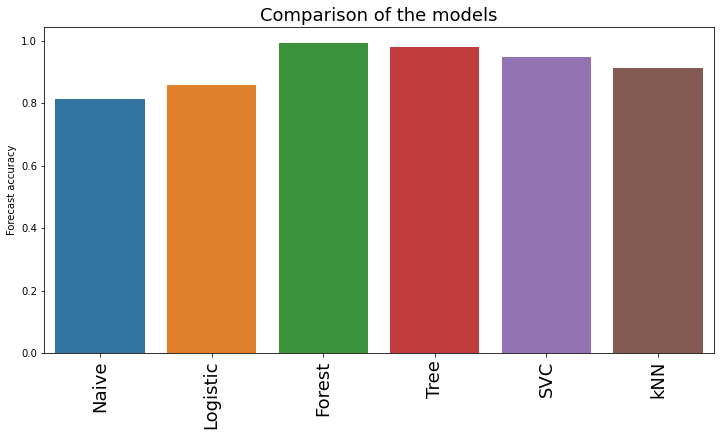

Confidence interval - Naive               : (0.811458865914793, 0.8151653066765283)
Confidence interval - Logistic            : (0.8578292089545724, 0.8604187276311924)
Confidence interval - Forest              : (0.9926169927600098, 0.9935070572522481)
Confidence interval - Tree                : (0.9799031690863075, 0.981492597850033)
Confidence interval - SVC                 : (0.9473312292818182, 0.9493427921286582)
Confidence interval - kNN                 : (0.9100431603170456, 0.9136227708752402)


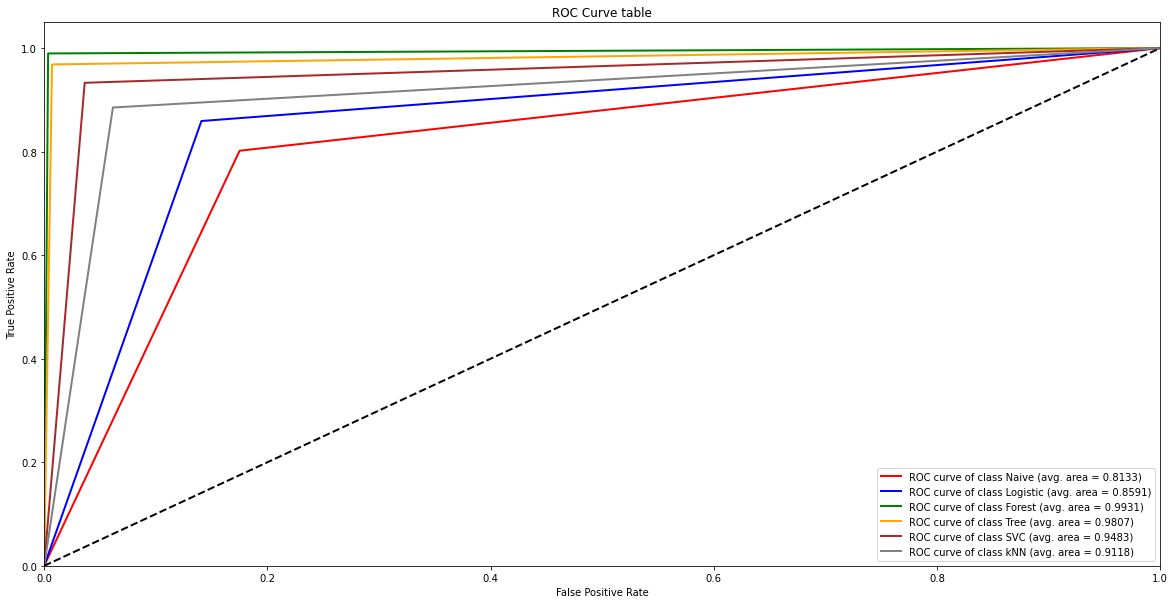

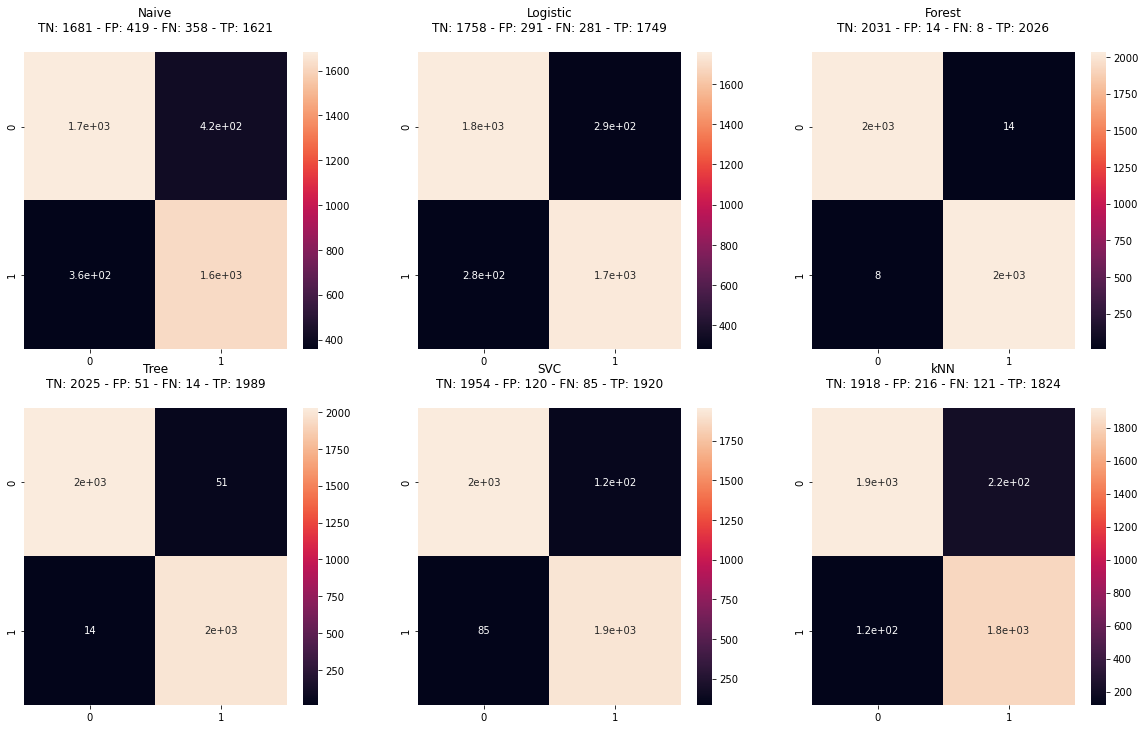

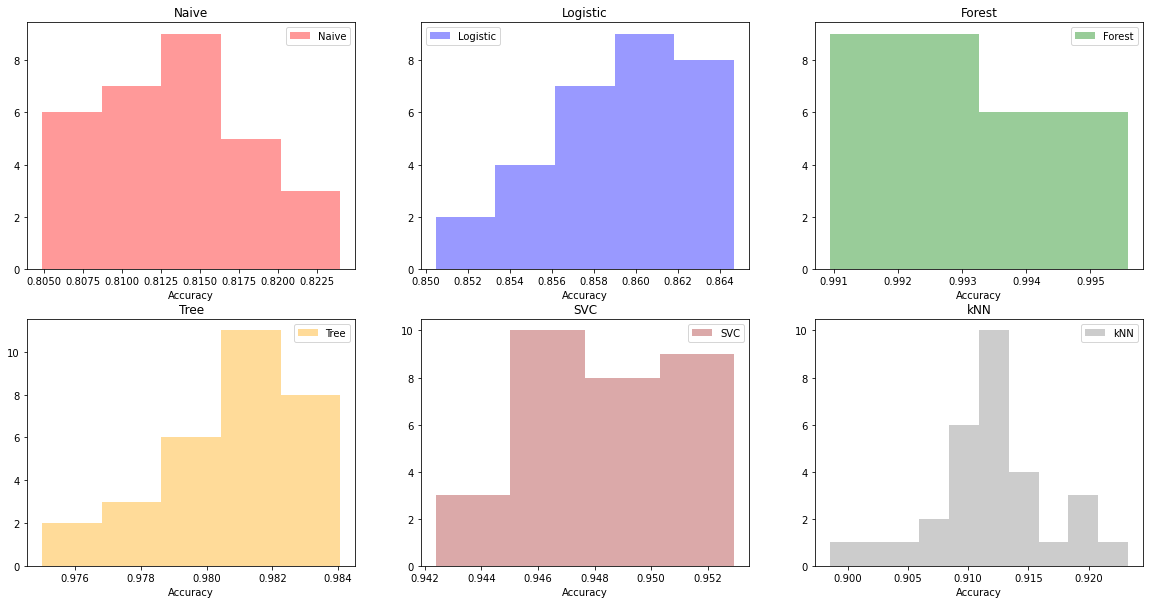

In [19]:
def train_models(x, y):
    train_loop = 30
    
    rnn = RepeatedEditedNearestNeighbours(sampling_strategy='majority')
    x, y = rnn.fit_resample(x, y)
    ros = RandomOverSampler(sampling_strategy='minority')
    x, y = ros.fit_resample(x, y)
    
    return train(x, y, train_loop, 1)
    
results = train_models(x, y)
plot_models_analysis(results)

## 4.3. K-Fold validation and a combination of Oversampling and Undersampling techniques - With skewed data, no attribute selection, normalized data with Standard Scaler, dataset size for test 30%

Accuracy Mean:
	Naive                    : 0.81606 %
	Logistic                 : 0.82821 %
	Forest                   : 0.99519 %
	Tree                     : 0.9856 %
	SVC                      : 0.79307 %
	kNN                      : 0.98294 %
Standard deviation:
	Naive                    : 0.00040034
	Logistic                 : 0.0030882
	Forest                   : 0.00031065
	Tree                     : 0.00069824
	SVC                      : 0.0003428
	kNN                      : 0.00099972
Coefficient of variation:
	Naive                    : 0.00049058
	Logistic                 : 0.0037288
	Forest                   : 0.00031215
	Tree                     : 0.00070844
	SVC                      : 0.00043225
	kNN                      : 0.0010171


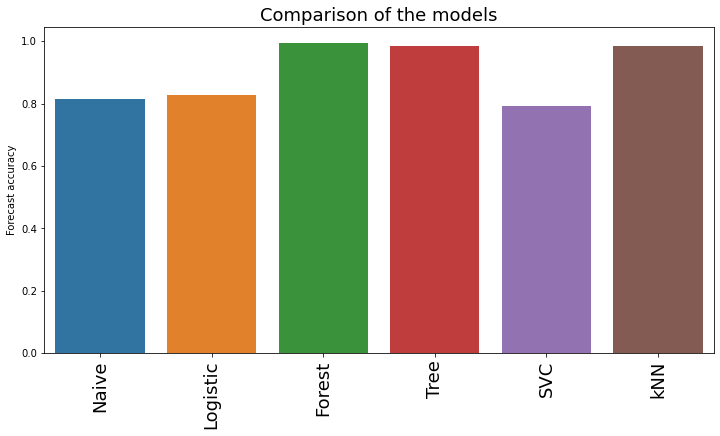

Confidence interval - Naive               : (0.8159102882220962, 0.8162016993985589)
Confidence interval - Logistic            : (0.827089546230185, 0.8293374870555352)
Confidence interval - Forest              : (0.9950783769655908, 0.9953045026027197)
Confidence interval - Tree                : (0.9853423832088157, 0.9858506400637752)
Confidence interval - SVC                 : (0.7929429219038843, 0.7931924501257223)
Confidence interval - kNN                 : (0.9825722653214777, 0.9832999771001414)


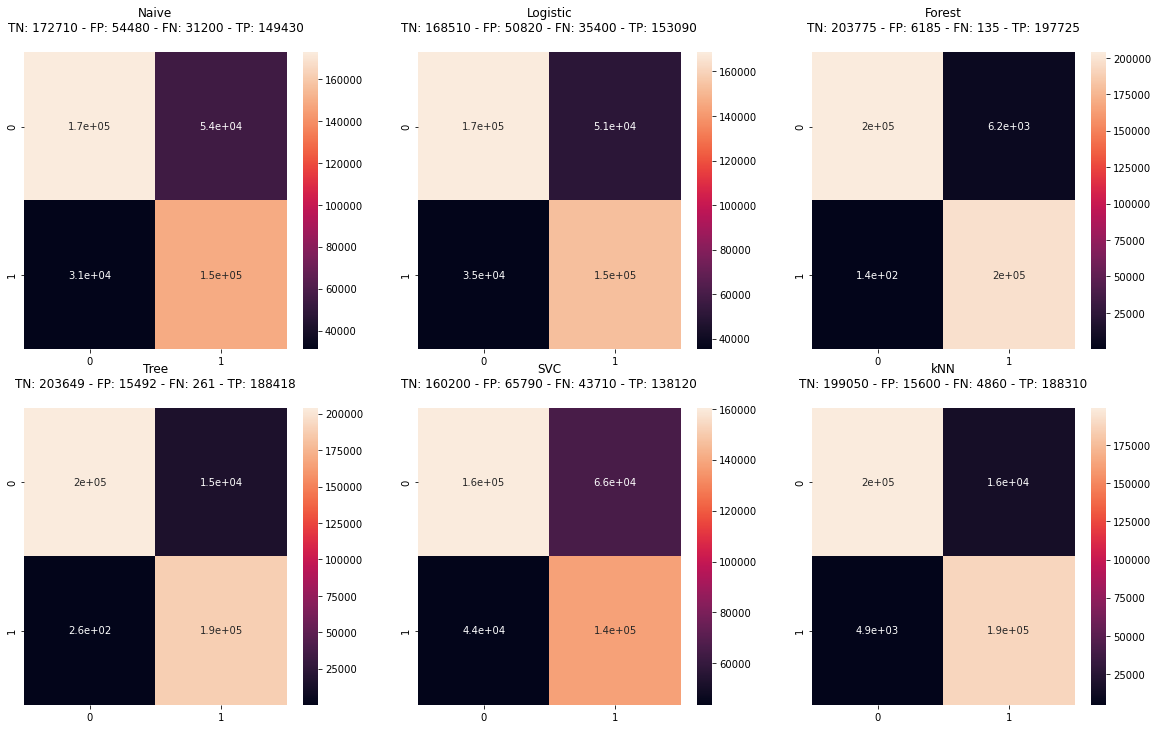

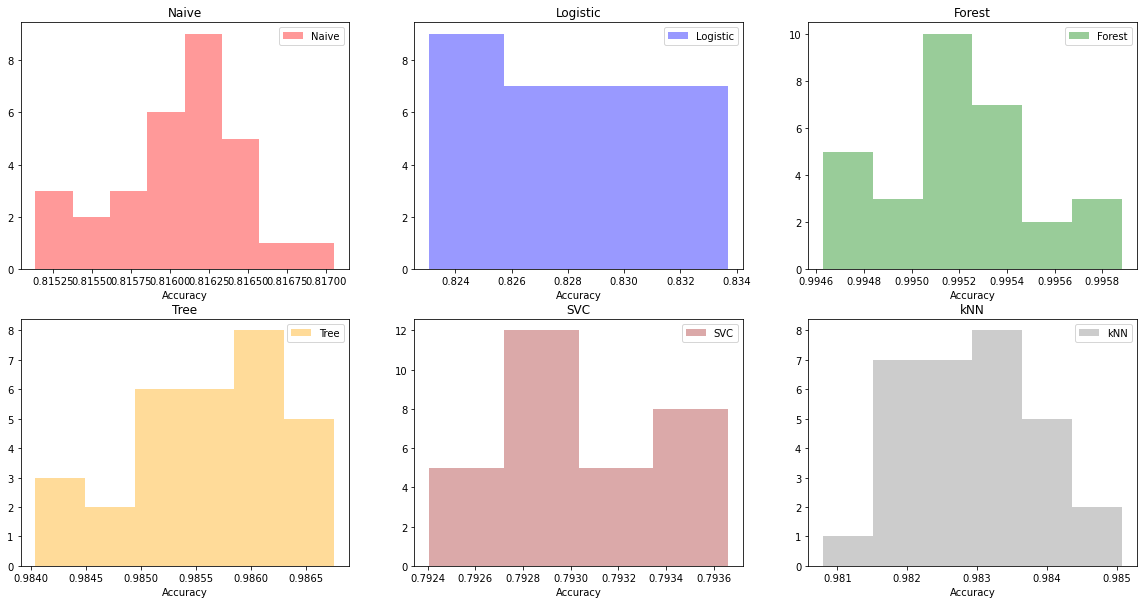

In [20]:
def train_kfold_models(x, y):
    train_loop = 30
    
    rnn = RepeatedEditedNearestNeighbours(sampling_strategy='majority')
    x, y = rnn.fit_resample(x, y)
    ros = RandomOverSampler(sampling_strategy='minority')
    x, y = ros.fit_resample(x, y)
    return train_kfold(x, y, train_loop)
    
results_kfold = train_kfold_models(x, y)
plot_kfold_analysis(results_kfold)

# 5. Conclusion

**Note:** Some trainning were carried out with Robust Scaler, but it reached a TPR lower than models in section 4.2.1., as well as a FPR higher than models in 4.2.1.

Even with no data transformation for skewed data, a good result was achieved with both algorithms during tests, section 4.1 and 4.2, using 30 train loops. But, during K-Fold cross-validation, section 4.3, just SVC algorithm achieved a real different result from previous sections - a lower result. Other algorithms reached a good result on cross-validation, a special consideration for Random Forest which reached the higher resultm 99.5%.

In [21]:
!jupyter nbconvert --to html --output "notebook_file" "credit_card.ipynb" --no-input

[NbConvertApp] Converting notebook credit_card.ipynb to html
[NbConvertApp] Writing 2942358 bytes to notebook_file.html
